In [1]:
# # Install once before starting.
# !pip install -U keras

In [2]:
import os

# Use Either one of these as backend.
os.environ["KERAS_BACKEND"] = "jax"
# os.environ["KERAS_BACKEND"] = "torch"

# There's some internal with JAX backend with keras3 right now,
# we'll update it as soon as there's any development.
# os.environ["KERAS_BACKEND"] = "jax"

In [3]:
import sys


if r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision" not in sys.path:
    sys.path.insert(0, r"C:\Users\vaibh\OneDrive\Desktop\Work\other_work_mine\Mine\keras-vision")


from keras_vision.MobileViT_v2 import build_MobileViT_v2

In [4]:
# https://github.com/apple/ml-cvnets/blob/main/docs/source/en/general/README-model-zoo.md#mobilevitv2-256x256

In [5]:
import torch

In [6]:
class WeightsLayerIterator:
    def __init__(self, pytorch_weights, keras_model):
        self.keras_model = keras_model
        self.pytorch_weights = pytorch_weights
        self.keras_layer_is_depthwise = False
        self.keras_layer_is_einsum = False

    def get_next_pytorch_weight(self):
        count = 0
        for idx, (param_name, param) in enumerate(self.pytorch_weights.items()):

            sentence = "{count} {param_name} ----> {param_shape}"
            if "num_batches_tracked" in param_name:
                continue
            if "conv.weight" in param_name:
                if self.keras_layer_is_depthwise:
                    param = param.permute(2, 3, 0, 1)
                else:
                    param = param.permute(2, 3, 1, 0)

            elif len(param.shape) == 2:
                param = param.T
            count += 1
            yield sentence.format(count=count, param_name=param_name, param_shape=param.shape), param

    def get_keras_weight(self):
        count = 0
        for idx, param in enumerate(self.keras_model.variables):
            if "seed_generator_state" in param.path:
                continue

            self.keras_layer_is_depthwise = True if "depthwise_conv2d" in param.path else False

            count += 1
            yield f"{count} {param.path} ----> {param.shape}", param

In [7]:
def get_pytorch2keras_layer_weights_mapping(pytorch_weights, keras_model):
    wl = WeightsLayerIterator(pytorch_weights=pytorch_weights, keras_model=keras_model)
    layer_mapping = {}

    for (keras_sentence, keras_weight), (pytorch_sentence, pytorch_weight) in zip(wl.get_keras_weight(), wl.get_next_pytorch_weight()):
        # # keras_layer_name = keras_weight.path.split("/")[0]
        # # layer_mapping.setdefault(keras_layer_name, list())
        # # layer_mapping[keras_layer_name].append(pytorch_weight.numpy())

        # if keras_weight.shape != pytorch_weight.shape:
        #     print(keras_sentence)
        #     print(pytorch_sentence)
        #     # pytorch_weight = pytorch_weight.reshape(pytorch_weight.shape[2], pytorch_weight.shape[3])
        #     # print(f"New :: keras:: {keras_weight.shape}, pytorch: {pytorch_weight.shape}")
        #     print("-------------")

        keras_layer_name = keras_weight.path.split("/")[0]
        layer_mapping.setdefault(keras_layer_name, list())
        layer_mapping[keras_layer_name].append(pytorch_weight.numpy())

    return layer_mapping

In [8]:
def load_weights_in_keras_model(keras_model, layer_mapping):
    for keras_layer in keras_model.layers[1:]:
        keras_layer_name = keras_layer.name

        if "global_average_pooling2d" in keras_layer_name:
            continue

        if "dropout" in keras_layer.name:
            continue

        from_pt = list(layer_mapping[keras_layer_name])
        keras_model.get_layer(keras_layer_name).set_weights(from_pt)
    return keras_model

In [9]:
def weights_port_agg(pytorch_weights_path, keras_models_type, save_name_prefix="keras", img_shape=(256, 256, 3), save_dir="."):
    os.makedirs(save_dir, exist_ok=True)
    for pytorch_weights_path, keras_model_config in zip(pytorch_weights_path, keras_models_type):
        
        # load weights and build keras model
        pytorch_weights = torch.load(pytorch_weights_path, map_location="cpu")
        keras_model = build_MobileViT_v2(width_multiplier=keras_model_config, input_shape=img_shape)

        # get weight 2 layer mapping.
        layer_mapping = get_pytorch2keras_layer_weights_mapping(
            pytorch_weights=pytorch_weights,
            keras_model=keras_model,
        )

        # load weights in keras model.
        keras_model = load_weights_in_keras_model(keras_model=keras_model, layer_mapping=layer_mapping)
        
        # save model weights        
        save_name = f"{save_name_prefix}_{os.path.splitext(os.path.split(pytorch_weights_path)[-1])[0]}.weights.h5"
        print(save_name)
        keras_model.save_weights(filepath=os.path.join(save_dir, save_name))
    
    return True

#### MobileViTv2 (256x256)

In [10]:
save_dir = "keras_mobilevitv2_weights"

In [11]:
pytorch_weights_0 = [
    r"v2_weights\mobilevitv2-im1k-256-0.5.pt",
    r"v2_weights\mobilevitv2-im1k-256-0.75.pt",
    r"v2_weights\mobilevitv2-im1k-256-1.0.pt",
    r"v2_weights\mobilevitv2-im1k-256-1.25.pt",
    r"v2_weights\mobilevitv2-im1k-256-1.5.pt",
    r"v2_weights\mobilevitv2-im1k-256-1.75.pt",
    r"v2_weights\mobilevitv2-im1k-256-2.0.pt",
]

img_shape_0 = (256, 256, 3)

keras_models_0 = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
    2.0,
]

weights_port_agg(pytorch_weights_0, keras_models_0, img_shape=img_shape_0, save_dir=save_dir)

keras_mobilevitv2-im1k-256-0.5.weights.h5
keras_mobilevitv2-im1k-256-0.75.weights.h5
keras_mobilevitv2-im1k-256-1.0.weights.h5
keras_mobilevitv2-im1k-256-1.25.weights.h5
keras_mobilevitv2-im1k-256-1.5.weights.h5
keras_mobilevitv2-im1k-256-1.75.weights.h5
keras_mobilevitv2-im1k-256-2.0.weights.h5


True

#### MobileViTv2 (Trained on 256x256 and Finetuned on 384x384)

In [12]:
pytorch_weights_1 = [
    r"v2_weights\mobilevitv2-im1k-256-f-384-0.5.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-0.75.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-1.0.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-1.25.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-1.5.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-1.75.pt",
    r"v2_weights\mobilevitv2-im1k-256-f-384-2.0.pt",
]

img_shape_1 = (384, 384, 3)

keras_models_1 = [
    0.5,
    0.75,
    1.0,
    1.25,
    1.5,
    1.75,
    2.0,
]

weights_port_agg(pytorch_weights_1, keras_models_1, img_shape=img_shape_1, save_dir=save_dir)

keras_mobilevitv2-im1k-256-f-384-0.5.weights.h5
keras_mobilevitv2-im1k-256-f-384-0.75.weights.h5
keras_mobilevitv2-im1k-256-f-384-1.0.weights.h5
keras_mobilevitv2-im1k-256-f-384-1.25.weights.h5
keras_mobilevitv2-im1k-256-f-384-1.5.weights.h5
keras_mobilevitv2-im1k-256-f-384-1.75.weights.h5
keras_mobilevitv2-im1k-256-f-384-2.0.weights.h5


True

#### MobileViTv2 (Trained on ImageNet-21k and Finetuned on ImageNet-1k 256x256)

In [13]:
pytorch_weights_2 = [
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-1.5.pt",
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-1.75.pt",
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-2.0.pt",
]

img_shape_2 = (256, 256, 3)

keras_models_2 = [
    1.5,
    1.75,
    2.0,
]

weights_port_agg(pytorch_weights_2, keras_models_2, img_shape=img_shape_2, save_dir=save_dir)

keras_mobilevitv2-im21k-256-f-im1k-256-1.5.weights.h5
keras_mobilevitv2-im21k-256-f-im1k-256-1.75.weights.h5
keras_mobilevitv2-im21k-256-f-im1k-256-2.0.weights.h5


True

#### MobileViTv2 (Trained on ImageNet-21k, Finetuned on ImageNet-1k 256x256, and Finetuned on ImageNet-1k 384x384)

In [14]:
pytorch_weights_3 = [
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-1.5.pt",
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-1.75.pt",
    r"v2_weights\mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-2.0.pt",
]

img_shape_3 = (384, 384, 3)

keras_models_3 = [
    1.5,
    1.75,
    2.0,
]

weights_port_agg(pytorch_weights_3, keras_models_3, img_shape=img_shape_3, save_dir=save_dir)

keras_mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-1.5.weights.h5
keras_mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-1.75.weights.h5
keras_mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-2.0.weights.h5


True

In [15]:
keras_model_0 = build_MobileViT_v2(width_multiplier=2.0, input_shape=(256, 256, 3))
keras_model_0.load_weights(r"keras_mobilevitv2_weights\keras_mobilevitv2-im1k-256-2.0.weights.h5")

keras_model_1 = build_MobileViT_v2(width_multiplier=2.0, input_shape=(384, 384, 3))
keras_model_1.load_weights(r"keras_mobilevitv2_weights\keras_mobilevitv2-im1k-256-f-384-2.0.weights.h5")


keras_model_2 = build_MobileViT_v2(width_multiplier=2.0, input_shape=(256, 256, 3))
keras_model_2.load_weights(r"keras_mobilevitv2_weights\keras_mobilevitv2-im21k-256-f-im1k-256-2.0.weights.h5")


keras_model_3 = build_MobileViT_v2(width_multiplier=2.0, input_shape=(384, 384, 3))
keras_model_3.load_weights(r"keras_mobilevitv2_weights\keras_mobilevitv2-im21k-256-f-im1k-256-f-im1k-384-2.0.weights.h5")

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

In [17]:
def test_prediction(*, image_path, model=None, image_shape=(224, 224), show=False):
    # Load and process the image
    img = cv2.imread(image_path, cv2.IMREAD_COLOR)
    img = img[:, :, ::-1]

    img = cv2.resize(img, image_shape)

    if show:
        plt.imshow(img)

    img = img  / 255. # Normalize pixel values to [0, 1]
    img = img.astype("float32")  # Ensure the correct type for TensorFlow
    # Add the batch dimension
    img = np.expand_dims(img, 0)  # Shape becomes (1, 256, 256, 3)

    # Perform prediction
    preds = model.predict(img, verbose=0)

    # Output prediction
    print(f"Model: {model.name}, Predictions: {preds.argmax()}")

Model: MobileViT-v2-2.0, Predictions: 282
Model: MobileViT-v2-2.0, Predictions: 281
Model: MobileViT-v2-2.0, Predictions: 388
Model: MobileViT-v2-2.0, Predictions: 145
--------------
Model: MobileViT-v2-2.0, Predictions: 282
Model: MobileViT-v2-2.0, Predictions: 281
Model: MobileViT-v2-2.0, Predictions: 388
Model: MobileViT-v2-2.0, Predictions: 145
--------------
Model: MobileViT-v2-2.0, Predictions: 282
Model: MobileViT-v2-2.0, Predictions: 281
Model: MobileViT-v2-2.0, Predictions: 388
Model: MobileViT-v2-2.0, Predictions: 145
--------------
Model: MobileViT-v2-2.0, Predictions: 282
Model: MobileViT-v2-2.0, Predictions: 281
Model: MobileViT-v2-2.0, Predictions: 388
Model: MobileViT-v2-2.0, Predictions: 145
--------------


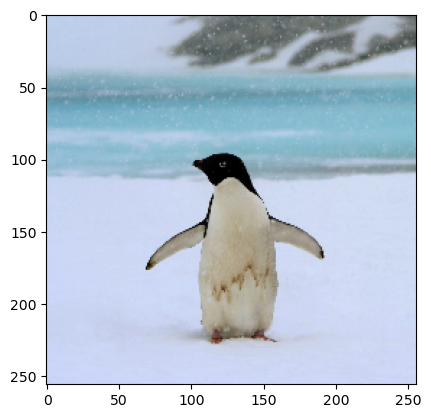

In [18]:
show = True
for keras_model, img_shape in (
    (keras_model_0, (256, 256)),
    (keras_model_1, (384, 384)),
    (keras_model_2, (256, 256)),
    (keras_model_3, (384, 384)),
):
    test_prediction(image_path=r"weight_porting_notebooks\cat.JPG", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"weight_porting_notebooks\cat_2.JPG", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"weight_porting_notebooks\pandas.JPG", model=keras_model, image_shape=img_shape, show=show)
    test_prediction(image_path=r"weight_porting_notebooks\penguin.JPG", model=keras_model, image_shape=img_shape, show=show)
    print("--------------")
    show = False